!!!!!!!!!!!!!!! EXPLANATION OF WHAT HAPPENS HERE (high-level)
!!!

Note: this notebook uses the csv files created in EDA.ipynb

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# loading data

In [3]:
# get names of data tables
files = os.listdir('./denormalised_data/')
csv_files = [file for file in files if file.endswith('.csv')]
table_names = [file.split('.')[0] for file in csv_files]
table_names

['assessment', 'studentassessment', 'studentinfo', 'studentvle', 'vle']

In [4]:
# create dict of DataFrames for each table 
dfs = {}

for table_name in table_names:
    dfs[f'{table_name}'] = pd.read_csv(f'./denormalised_data/{table_name}.csv')


In [5]:
print("SIZE OF TABLES \n")

for table_name, df in dfs.items():
    print(table_name, df.shape)

SIZE OF TABLES 

assessment (206, 11)
studentassessment (173912, 10)
studentinfo (32593, 15)
studentvle (10655280, 7)
vle (6364, 7)


In [66]:
# create df for each csv
df_assessment = dfs['assessment'].copy()
df_studentassessment = dfs['studentassessment'].copy()
df_studentinfo = dfs['studentinfo'].copy()
df_studentvle = dfs['studentvle'].copy()
df_vle = dfs['vle'].copy()

# look at specific course

In [67]:
# select a course to look at

# I prefer a course with 4 presentations to have as much data as possible
unique_course_presentations = df_assessment[['code_module', 'code_presentation']].drop_duplicates().reset_index(drop=True)
unique_course_presentations.code_module.value_counts()

code_module
BBB    4
DDD    4
FFF    4
EEE    3
GGG    3
AAA    2
CCC    2
Name: count, dtype: int64

In [68]:
relevant_modules = unique_course_presentations.code_module.value_counts()[unique_course_presentations.code_module.value_counts() == 4].index

In [69]:
# I prefer a course with many students

# check how many rows there are for each course with 4 presentations
df_studentinfo[df_studentinfo.code_module.isin(relevant_modules)].code_module.value_counts()

code_module
BBB    7909
FFF    7762
DDD    6272
Name: count, dtype: int64

-> we will look at course 'BBB'

In [70]:
# keep rows for course 'BBB' in each df
selected_course = 'BBB'

df_assessment = df_assessment[df_assessment.code_module==selected_course]
df_studentassessment = df_studentassessment[df_studentassessment.code_module==selected_course]
df_studentinfo = df_studentinfo[df_studentinfo.code_module==selected_course]
df_studentvle = df_studentvle[df_studentvle.code_module==selected_course]
df_vle = df_vle[df_vle.code_module==selected_course]

In [71]:
# check presentation length & number of assessments per presentation
code_presentations = df_assessment.code_presentation.unique()
module_presentation_overview = df_assessment[['code_presentation', 'module_presentation_length']].value_counts()
module_presentation_overview

code_presentation  module_presentation_length
2013B              240                           12
2013J              268                           12
2014B              234                           12
2014J              262                            6
Name: count, dtype: int64

In [72]:
# add final_result course to each student assessment
df_studentassessment = df_studentassessment.merge(df_studentinfo[['final_result', 'id_student']],
                     on=['id_student'],
                     how='left'
                     )
df_studentassessment

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,due_date_assessment,assessment_type,date_submitted_relative,final_result
0,14984,1008675,19,0,70.0,BBB,2013B,19.0,TMA,0.0,Pass
1,14984,1098728,19,0,75.0,BBB,2013B,19.0,TMA,0.0,Fail
2,14984,1413989,30,0,86.0,BBB,2013B,19.0,TMA,11.0,Withdrawn
3,14984,1413989,30,0,86.0,BBB,2013B,19.0,TMA,11.0,Withdrawn
4,14984,1436591,14,0,77.0,BBB,2013B,19.0,TMA,-5.0,Distinction
...,...,...,...,...,...,...,...,...,...,...,...
44581,15024,554599,203,0,72.0,BBB,2014J,201.0,TMA,2.0,Pass
44582,15024,555749,201,0,95.0,BBB,2014J,201.0,TMA,0.0,Pass
44583,15024,556644,193,0,77.0,BBB,2014J,201.0,TMA,-8.0,Distinction
44584,15024,556863,197,0,84.0,BBB,2014J,201.0,TMA,-4.0,Withdrawn


In [73]:
# let's check if there's a difference in when students submit their assessment by final_result
df_studentassessment.groupby('final_result').date_submitted_relative.mean()


final_result
Distinction    0.082843
Fail          -0.548387
Pass           0.548329
Withdrawn     -5.408013
Name: date_submitted_relative, dtype: float64

ANOVA test results: F=31.541130329196356, p-value=2.0531012858059815e-14


Text(0, 0.5, 'Date Submitted Relative')

<Figure size 1000x600 with 0 Axes>

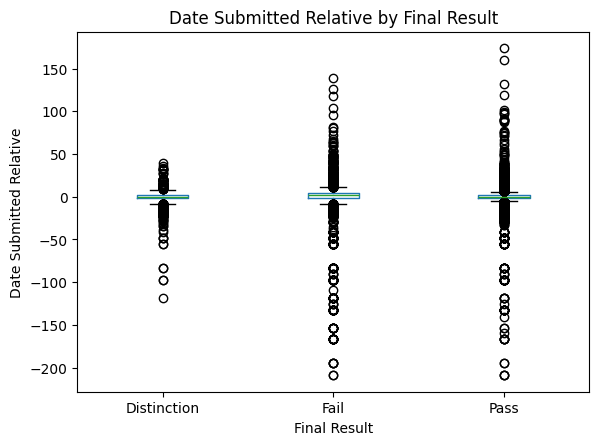

In [74]:
# statistically test the difference between final_result (excluding withdrawn students)
df_studentassessment_exclude_withdrawn = df_studentassessment[df_studentassessment.final_result!='Withdrawn'].copy()

# ANOVA ; test difference in means 
from scipy.stats import f_oneway

anova_results = f_oneway(
    *[group['date_submitted_relative'].values for name, group in df_studentassessment_exclude_withdrawn.groupby('final_result')]
)

print(f'ANOVA test results: F={anova_results.statistic}, p-value={anova_results.pvalue}')

# create box and whisker plot
plt.figure(figsize=(10, 6))
df_studentassessment_exclude_withdrawn.boxplot(column='date_submitted_relative', by='final_result', grid=False)
plt.title('Date Submitted Relative by Final Result')
plt.suptitle('')  # Suppress the default title to only show the one above
plt.xlabel('Final Result')
plt.ylabel('Date Submitted Relative')

-> there's a difference in means between the three groups. The plot shows less variance for the people with 'Distinction' as final result

  Multiple Comparison of Means - Tukey HSD, FWER=0.01   
   group1   group2 meandiff p-adj  lower   upper  reject
--------------------------------------------------------
Distinction   Fail  -0.6312 0.0019 -1.171 -0.0914   True
Distinction   Pass   0.4655 0.0069 0.0177  0.9132   True
       Fail   Pass   1.0967    0.0 0.6877  1.5057   True
--------------------------------------------------------


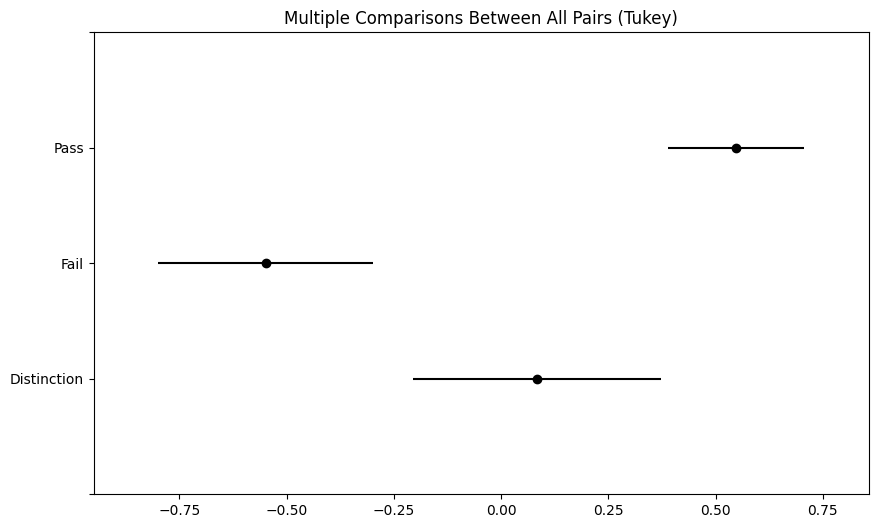

In [75]:
# look which groups are different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = pairwise_tukeyhsd(
    endog=df_studentassessment_exclude_withdrawn['date_submitted_relative'],
    groups=df_studentassessment_exclude_withdrawn['final_result'],
    alpha=0.01
)
print(tukey_results)

tukey_plot = tukey_results.plot_simultaneous()


-> all group means are very significantly different from each other.

In [76]:
'''
find a relationship between studentvle and results
'''

'\nfind a relationship between studentvle and results\n'

In [77]:
df_studentassessment_exclude_withdrawn


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,due_date_assessment,assessment_type,date_submitted_relative,final_result
0,14984,1008675,19,0,70.0,BBB,2013B,19.0,TMA,0.0,Pass
1,14984,1098728,19,0,75.0,BBB,2013B,19.0,TMA,0.0,Fail
4,14984,1436591,14,0,77.0,BBB,2013B,19.0,TMA,-5.0,Distinction
5,14984,1480800,15,0,77.0,BBB,2013B,19.0,TMA,-4.0,Pass
6,14984,1493476,19,0,75.0,BBB,2013B,19.0,TMA,0.0,Pass
...,...,...,...,...,...,...,...,...,...,...,...
44580,15024,554048,200,0,94.0,BBB,2014J,201.0,TMA,-1.0,Pass
44581,15024,554599,203,0,72.0,BBB,2014J,201.0,TMA,2.0,Pass
44582,15024,555749,201,0,95.0,BBB,2014J,201.0,TMA,0.0,Pass
44583,15024,556644,193,0,77.0,BBB,2014J,201.0,TMA,-8.0,Distinction


In [78]:
# add final_result course to each student vle
df_studentvle = df_studentvle.merge(df_studentinfo[['final_result', 'id_student']],
                     on=['id_student'],
                     how='left'
                     )
df_studentassessment_exclude_withdrawn = df_studentvle[df_studentvle.final_result!='Withdrawn'].copy()
df_studentassessment_exclude_withdrawn


,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,final_result
0,BBB,2013B,333129,542864,-9,3,homepage,Fail
1,BBB,2013B,333129,542808,-9,4,forumng,Fail
2,BBB,2013B,333129,542795,-9,1,forumng,Fail
3,BBB,2013B,333129,542808,-9,6,forumng,Fail
4,BBB,2013B,333129,542795,-9,1,forumng,Fail
...,...,...,...,...,...,...,...,...
1620335,BBB,2014J,627269,913466,262,1,forumng,Pass
1620336,BBB,2014J,624342,913473,262,1,homepage,Pass
1620337,BBB,2014J,512722,913473,262,3,homepage,Pass
1620338,BBB,2014J,391937,913473,262,1,homepage,Pass


In [132]:
# check average sum_click per interaction
df_studentassessment_exclude_withdrawn.groupby('final_result').sum_click.mean()

final_result
Distinction    3.489702
Fail           2.948181
Pass           3.396576
Name: sum_click, dtype: float64

In [151]:
# total per student for each result

# get unique final results
final_results = df_studentassessment_exclude_withdrawn.final_result.unique()

data = []

for result in final_results:
    average_sum_clicks_per_student = df_studentassessment_exclude_withdrawn[df_studentassessment_exclude_withdrawn.final_result==result].groupby(['code_presentation', 'id_student']).sum_click.sum().mean()
    row_data = {
        'result': result,
        'average_sum_clicks_per_student': average_sum_clicks_per_student
    } 
    data.append(row_data)

df_sum_clicks_per_student = pd.DataFrame(data)
df_sum_clicks_per_student.round()

,result,average_sum_clicks_per_student
0,Fail,377.0
1,Distinction,1472.0
2,Pass,1062.0


-> students who fail have on average less clicks per interaction

In [159]:
# calculate interaction differences between different groups per activity_type
data = []

# get unique activity types and final results
activity_types = df_studentassessment_exclude_withdrawn.activity_type.unique()
final_results = df_studentassessment_exclude_withdrawn.final_result.unique()


for activity_type in activity_types:
    row_data = {'activity_type': activity_type}
    
    for result in final_results:
        sum_clicks = df_studentassessment_exclude_withdrawn[
            (df_studentassessment_exclude_withdrawn.activity_type == activity_type) &
            (df_studentassessment_exclude_withdrawn.final_result == result)
        ].sum_click.sum()
        n_students_with_result = len(df_studentinfo[df_studentinfo.final_result==result])
        
        sum_clicks_per_student = sum_clicks / n_students_with_result

        row_data[result] = sum_clicks_per_student
    
    data.append(row_data)

df_activity_type_interaction = pd.DataFrame(data)
df_activity_type_interaction.round()

,activity_type,Fail,Distinction,Pass
0,homepage,86.0,307.0,231.0
1,forumng,134.0,680.0,421.0
2,subpage,26.0,66.0,54.0
3,oucontent,45.0,248.0,207.0
4,resource,19.0,49.0,43.0
5,url,8.0,21.0,17.0
6,glossary,1.0,3.0,2.0
7,ouelluminate,0.0,0.0,0.0
8,quiz,40.0,105.0,98.0
9,sharedsubpage,0.0,0.0,0.0


In [160]:
# look at the same table, expressed in percentages 

df_activity_type_interaction.set_index('activity_type', inplace=True)

row_sums = df_activity_type_interaction.sum(axis=1)
df_activity_type_interaction_percentage = df_activity_type_interaction.div(row_sums, axis=0) * 100

df_activity_type_interaction_percentage.reset_index(inplace=True)

df_activity_type_interaction_percentage.sort_values(by='Distinction', ascending=False).round()

,activity_type,Fail,Distinction,Pass
11,questionnaire,5.0,57.0,39.0
1,forumng,11.0,55.0,34.0
6,glossary,14.0,51.0,35.0
10,oucollaborate,11.0,50.0,40.0
3,oucontent,9.0,50.0,41.0
0,homepage,14.0,49.0,37.0
5,url,18.0,46.0,36.0
2,subpage,18.0,45.0,37.0
4,resource,18.0,44.0,39.0
8,quiz,16.0,43.0,40.0


In [161]:
df_activity_type_interaction_percentage.sort_values(by='Pass', ascending=False).round()

,activity_type,Fail,Distinction,Pass
3,oucontent,9.0,50.0,41.0
8,quiz,16.0,43.0,40.0
10,oucollaborate,11.0,50.0,40.0
7,ouelluminate,19.0,43.0,39.0
11,questionnaire,5.0,57.0,39.0
4,resource,18.0,44.0,39.0
0,homepage,14.0,49.0,37.0
2,subpage,18.0,45.0,37.0
5,url,18.0,46.0,36.0
9,sharedsubpage,23.0,42.0,35.0


In [129]:
df_activity_type_interaction_percentage.sort_values(by='Fail', ascending=False).round()

,activity_type,Fail,Distinction,Pass
9,sharedsubpage,23.0,42.0,35.0
7,ouelluminate,19.0,43.0,39.0
2,subpage,18.0,45.0,37.0
5,url,18.0,46.0,36.0
4,resource,18.0,44.0,39.0
8,quiz,16.0,43.0,40.0
6,glossary,14.0,51.0,35.0
0,homepage,14.0,49.0,37.0
1,forumng,11.0,55.0,34.0
10,oucollaborate,11.0,50.0,40.0


-> When looking at the average sum_clicks per student, per activity_type we notice
- both students with 'Pass' and 'Distinction' have a high sum_click for 'oucollaborate', 'oucontent', 'questionnaire' ; students with 'Fail' don't focus on these activity_types
- students with 'Fail' have a relative high sum_click for: 'resource', 'sharedsubpage', 'subpage', 'url' when compared to students with 'Pass' and 'Distinction' 

